In [1]:
from matplotlib import pyplot as plt
import numpy as np
from fpl import FPL
import aiohttp
import asyncio
import pandas as pd
from random import shuffle
from collections import defaultdict
from scipy.stats import skewnorm
import glob
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from models import AverageModel, MedianModel, LinearRegressionModel, SimpleConvModel
print("hello FPL")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
hello FPL


Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards'],
      dtype='object')
Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards'],
      dtype='object')


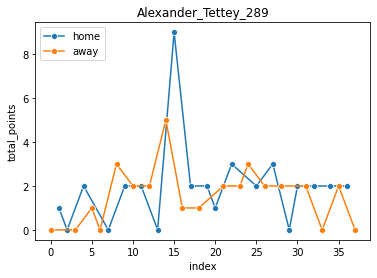

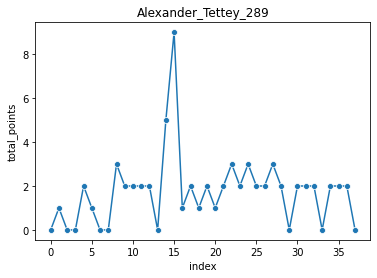

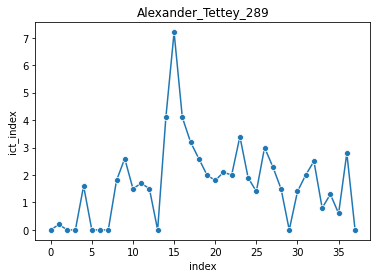

Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards'],
      dtype='object')
Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards'],
      dtype='object')
In

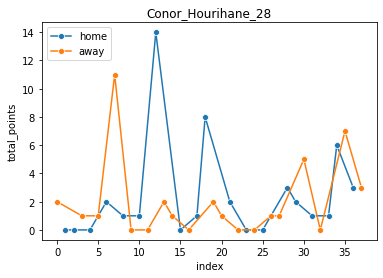

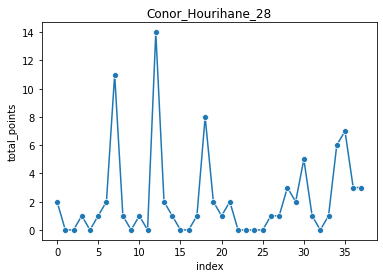

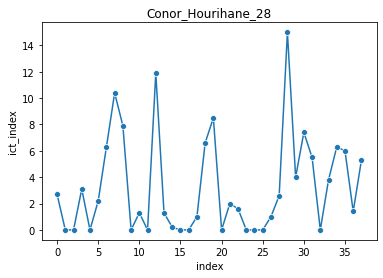

In [2]:

def plot_performance_curves(player_path, minute_threshold = 1000):
    player_data = pd.read_csv(f"{player_path}/gw.csv")
    print(player_data.columns)
    if player_data['minutes'].sum() > minute_threshold:
        player_data = player_data.reset_index()
        home_data = player_data[player_data["was_home"]]
        away_data = player_data[~player_data["was_home"]]
        player_name = player_path.split("/")[-1]
        sns.lineplot(y='total_points', x =  "index", data = home_data, marker = 'o', label = 'home')
        sns.lineplot(y='total_points', x =  "index", data = away_data, marker = 'o', label="away")
        plt.legend(loc='upper left')
        plt.title(player_name)
        plt.show()

        sns.lineplot(x='index', y='total_points', data = player_data, marker = 'o')
        plt.title(player_name)
        plt.show()

        sns.lineplot(x='index', y='ict_index', data = player_data, marker = 'o')
        plt.title(player_name)
        plt.show()

player_paths = glob.glob("../data/2019-20/players/*")
shuffle(player_paths)
for player_path in player_paths[0:5]:
    plot_performance_curves(player_path)

In [7]:
def get_total_points_batch( window_size = 5, minutes_per_season_threshold = 1000, minutes_per_game_threshold = 30):
    player_paths = glob.glob("../data/2019-20/players/*")
    X = []
    for player_path in player_paths:
        player_data = pd.read_csv(f"{player_path}/gw.csv")
        player_data = player_data[player_data['minutes'] > minutes_per_game_threshold]
        if player_data['minutes'].sum() > minutes_per_season_threshold:
            x = player_data["total_points"].values
            num_windows = len(x) // window_size
            x = x[:num_windows * window_size]
            x = x.reshape((num_windows, window_size))
            X.extend(x)
    X = np.array(X)
    shuffle(X)
    return X[:,:-1], X[:,-1]

X, Y = get_total_points_batch()
X.shape, Y.shape

((1388, 4), (1388,))

In [4]:
def get_real_signals_batch( window_size = 5, minutes_per_season_threshold = 1000, minutes_per_game_threshold = 30, num_features = 7):
    player_paths = glob.glob("../data/2019-20/players/*")
    X = []
    for player_path in player_paths:
        player_data = pd.read_csv(f"{player_path}/gw.csv")
        player_data = player_data[player_data['minutes'] > minutes_per_game_threshold]
        if player_data['minutes'].sum() > minutes_per_season_threshold:
            x = player_data[['total_points', 'yellow_cards', 'assists', 'ict_index', 'saves', 'goals_scored', 'goals_conceded']].values
            num_windows = len(x) // window_size
            x = x[:num_windows * window_size, :]
            x = x.reshape((num_windows, window_size, num_features))
            X.extend(x)
    X = np.array(X)
    shuffle(X)
    return X[:,:-1, :].transpose((0, 2, 1)), X[:,-1, :]

X_rs, Y_rs = get_real_signals_batch()
X_rs.shape

(1388, 7, 4)

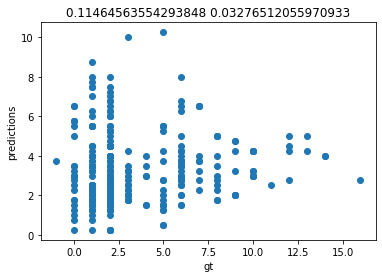

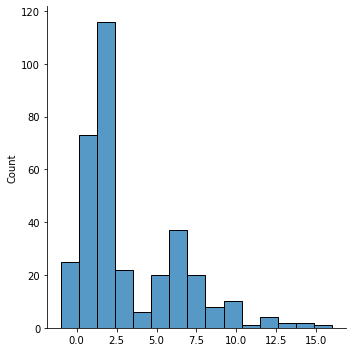

<models.AverageModel object at 0x7f068f3acc10> 2.4541306436119115 2.526657060518732


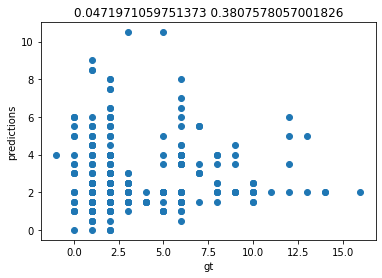

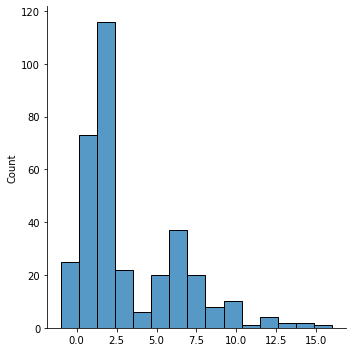

<models.MedianModel object at 0x7f068f2e3090> 2.2905859750240154 2.5


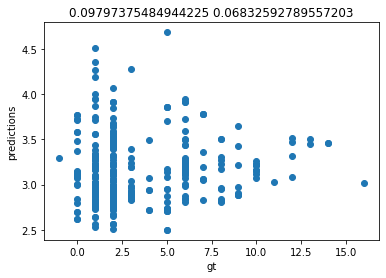

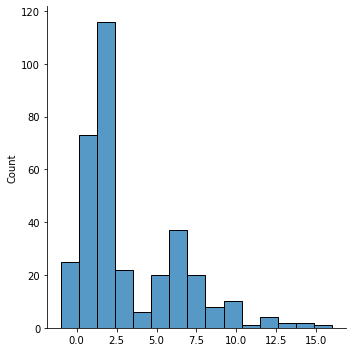

<models.LinearRegressionModel object at 0x7f068da0a490> 2.256218751681337 2.3412690028791983
[0.06976361 0.03748544 0.06592924 0.01556315] 2.503742711111254


In [8]:


X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
for model in [AverageModel(), MedianModel(), LinearRegressionModel()]:
    model.fit(X_train, Y_train)
    train_loss = model.eval(X_train, Y_train)
    test_loss = model.eval(X_test, Y_test)
    model.visualize_predictions(X_test, Y_test)
    print(model, train_loss, test_loss)
    if isinstance(model, LinearRegressionModel):
        print(model.model.coef_, model.model.intercept_)

In [6]:


X_train, X_test, Y_train, Y_test = train_test_split(X_rs, Y_rs)
for model in [SimpleConvModel()]:
    model.fit(X_train, Y_train)
    train_loss = model.eval(X_train, Y_train)
    test_loss = model.eval(X_test, Y_test)
    print(model, train_loss, test_loss)

<models.SimpleConvModel object at 0x7f06ec5825d0> 1.5752625693324205 1.5265644640673535
